In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import argparse
from pathlib import Path

In [3]:
from june.geography import Geography
from june.demography.demography import (
    load_age_and_sex_generators_for_bins,
    Demography,
    Population,
    load_comorbidity_data,
    generate_comorbidity,
)
from june.paths import data_path, configs_path
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import ImmunitySetter
from june.epidemiology.infection import Infection, HealthIndexGenerator, InfectionSelector, InfectionSelectors
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.interaction import Interaction
from june.groups import Hospital, Hospitals, Cemeteries
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.policy import Policy, Policies
from june.records import Record
from june.simulator import Simulator
from june.records import Record, RecordReader

from camps.activity import CampActivityManager
from camps.paths import camp_data_path, camp_configs_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camps.camp_creation import (
    generate_empty_world,
    populate_world,
    distribute_people_to_households,
)  # this is loaded from the ../camp_scripts folder

from june.tracker.tracker import Tracker

No --data argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/UNGP-settlement-modelling-private/data
No --configs argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/JUNE-private/june/configs


2022-09-26 09:43:56,041 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/UNGP-settlement-modelling-private/camp_data
2022-09-26 09:43:56,043 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/home/joseph/Documents/PhD/UN_Work/UNGP-settlement-modelling-private/configs_camps


In [4]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from camps.groups import LearningCenters
from camps.distributors import LearningCenterDistributor
from camps.groups import PlayGroups, PlayGroupDistributor
from camps.groups import EVouchers, EVoucherDistributor
from camps.groups import NFDistributionCenters, NFDistributionCenterDistributor
from camps.groups import SheltersVisitsDistributor
from camps.groups import InformalWorks, InformalWorkDistributor

In [5]:
Results_Path = Path("results")

Config_File_Path = camp_configs_path / "config_demo.yaml"
Interactions_File_Path = camp_configs_path / "defaults/interaction/interaction_Survey.yaml"
Policies_File_Path = camp_configs_path / "defaults/policy/simple_policy.yaml"
Hospitals_File_Path = camp_data_path / "input/hospitals/hospitals.csv"
comorbidity_multipliers_path = camp_configs_path / "defaults/comorbidities.yaml"
male_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_male_comorbidities.csv"
female_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_female_comorbidities.csv"

## Initialize the world

When we create the camp to be simulated, we call this the 'world'. The world is initialised after specifying which geographical regions you want to simulate. We can do this by using the `filter_key` argument in the `generate_empty_world` function. Cox's Bazar Expansion Site is made up of camps (which we call regions), UNHCR blocks (which we call super areas) and Mahjee blocks (which we call areas). These are the 3 heirarchical levels on which our model works. You can pass lists of the regions/super_areas/areas to the function here. Alternatively, by leaving the function empty you can generate the entire Cox's Bazar Expansion Site consisting of 112 super areas.

In [6]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2022-09-26 09:43:58,312 - june.geography.geography - INFO - There are 65 areas and 4 super_areas and 1 regions in the world.


In [7]:
# populate empty world
populate_world(world)

In [8]:
# distribute people to households
distribute_people_to_households(world)

Distributing 467 people to CXB-219-001
Distributing 369 people to CXB-219-002
Distributing 330 people to CXB-219-003
Distributing 386 people to CXB-219-004
Distributing 313 people to CXB-219-005
Distributing 331 people to CXB-219-006
Distributing 259 people to CXB-219-007
Distributing 349 people to CXB-219-009
Distributing 274 people to CXB-219-010
Distributing 249 people to CXB-219-011
Distributing 464 people to CXB-219-012
Distributing 418 people to CXB-219-013
Distributing 460 people to CXB-219-014
Distributing 383 people to CXB-219-017
Distributing 417 people to CXB-219-020
Distributing 425 people to CXB-219-021
Distributing 414 people to CXB-219-022
Distributing 383 people to CXB-219-024
Distributing 377 people to CXB-219-025
Distributing 380 people to CXB-219-026
Distributing 413 people to CXB-219-027
Distributing 392 people to CXB-219-028
Distributing 331 people to CXB-219-029
Distributing 459 people to CXB-219-030
Distributing 394 people to CXB-219-032
Distributing 339 people t

In [9]:
LearningCenters.Get_Interaction(Interactions_File_Path)
world.learning_centers = LearningCenters.for_areas(world.areas)

learningcenter_distributor = LearningCenterDistributor.from_file(world.learning_centers)

learningcenter_distributor.distribute_teachers_to_learning_centers(world.areas)
learningcenter_distributor.distribute_kids_to_learning_centers(world.areas)

2022-09-26 09:44:06,476 - learning_centers - INFO - There are 1243 learning center(s)


In [10]:
# distribute hospitals
Hospitals.Get_Interaction(Interactions_File_Path)
IsolationUnits.Get_Interaction(Interactions_File_Path)

hospitals = Hospitals.from_file(
    filename=Hospitals_File_Path
)


for hospital in hospitals:
    hospital.area = world.areas.get_closest_area(hospital.coordinates)
    
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(
    hospitals, medic_min_age=20, patients_per_medic=10
)
hospital_distributor.assign_closest_hospitals_to_super_areas(
    world.super_areas
)

world.isolation_units = IsolationUnits([IsolationUnit(area=hospital.area) for hospital in world.hospitals])
hospital_distributor.distribute_medics_from_world(world.people)

2022-09-26 09:44:07,615 - hospitals - INFO - There are 8 hospitals in the world.
2022-09-26 09:44:07,629 - isolation units - INFO - There are 8 isolation unit(s)


In [11]:
PumpLatrines.Get_Interaction(Interactions_File_Path)
world.pump_latrines = PumpLatrines.for_areas(world.areas)

PlayGroups.Get_Interaction(Interactions_File_Path)
world.play_groups = PlayGroups.for_areas(world.areas)

DistributionCenters.Get_Interaction(Interactions_File_Path)
world.distribution_centers = DistributionCenters.for_areas(world.areas)

Communals.Get_Interaction(Interactions_File_Path)
world.communals = Communals.for_areas(world.areas)

FemaleCommunals.Get_Interaction(Interactions_File_Path)
world.female_communals = FemaleCommunals.for_areas(world.areas)

Religiouss.Get_Interaction(Interactions_File_Path)
world.religiouss = Religiouss.for_areas(world.areas)

EVouchers.Get_Interaction(Interactions_File_Path)
world.e_vouchers = EVouchers.for_areas(world.areas)

NFDistributionCenters.Get_Interaction(Interactions_File_Path)
world.n_f_distribution_centers = NFDistributionCenters.for_areas(world.areas)

InformalWorks.Get_Interaction(Interactions_File_Path)
world.informal_works = InformalWorks.for_areas(world.areas)

2022-09-26 09:44:07,709 - social_venue - INFO - Domain 0 has 82 pump_latrines(s)
2022-09-26 09:44:07,837 - social_venue - INFO - Domain 0 has 536 play_groups(s)
2022-09-26 09:44:07,881 - social_venue - INFO - Domain 0 has 21 distribution_centers(s)
2022-09-26 09:44:07,971 - social_venue - INFO - Domain 0 has 115 communals(s)
2022-09-26 09:44:08,039 - social_venue - INFO - Domain 0 has 67 female_communals(s)
2022-09-26 09:44:09,052 - social_venue - INFO - Domain 0 has 2065 religiouss(s)
2022-09-26 09:44:09,097 - social_venue - INFO - Domain 0 has 7 e_vouchers(s)
2022-09-26 09:44:09,151 - social_venue - INFO - Domain 0 has 41 n_f_distribution_centers(s)
2022-09-26 09:44:09,195 - social_venue - INFO - Domain 0 has 80 informal_works(s)


In [12]:
world.cemeteries = Cemeteries()

cemetery not defined in interaction yaml or defualt options


## Geography exploration

The geography is initialised first and can be explored.

### UNHCR camp blocks inside the World

In [13]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [14]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [15]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [16]:
areas[:5]

['CXB-219-001', 'CXB-219-002', 'CXB-219-003', 'CXB-219-004', 'CXB-219-005']

## Demography exploration

Once we have populated the 'digital twin' we can explore some of the attributes of the people we have created in the simulation.

### UNHCR block residents

In [17]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [18]:
sample_sexes[:5], sample_ages[:5]

(['f', 'f', 'f', 'm', 'm'], [34, 38, 30, 45, 61])

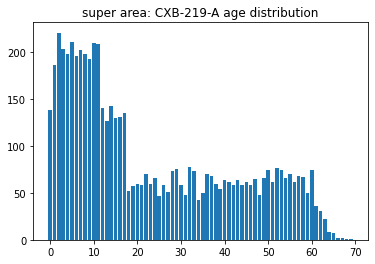

In [19]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [20]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49%


## Households

In this model, we will use the term 'family' and 'household' interchangeably. After populating the 'digital twin', we need to cluster people into families. To do this, we take account of age structure so that children live with adults, that there are some intergenerational households and such that we might also have some households of only adults.

### Household size distribution

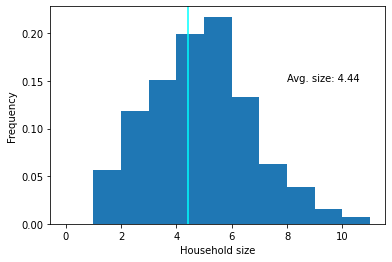

In [21]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

Shelters house people in the camp. Since we know that families (houseohlds) often share shelters with other families, we can set the `sharing_shelter_ratio` to cluster families into shared shelters.

In [22]:
Shelters.Get_Interaction(Interactions_File_Path)
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

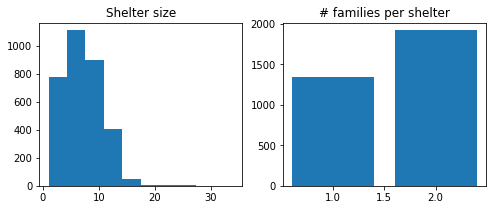

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

Once different activity locations are seeded in the 'digital twin' we can explore how many there are in different areas of the twin, and their coordinates to check they've all been added correctly.

### Pumps and latrines 

In [24]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [25]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 2 pumps and latrines in area CXB-219-001


### Informal work

In [26]:
Informal_work_Sites = []
for informal_work in world.areas.members[0].informal_works:
    Informal_work_Sites.append(informal_work)

In [27]:
print ('There are {} informal work sites in area {}'.format(len(Informal_work_Sites), world.areas.members[0].name))

There are 2 informal work sites in area CXB-219-001


### Distribution centers

In [28]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [29]:
distribution_centers[0].coordinates

array([21.2136    , 92.15678833])

### Non-food Distribution centers

In [30]:
non_food_distribution_centers = []
for center in world.n_f_distribution_centers:
    non_food_distribution_centers.append(center)

In [31]:
non_food_distribution_centers[0].coordinates

array([21.21268167, 92.1438    ])

### E-Voucher outlets

In [32]:
e_voucher_outlets = []
for center in world.e_vouchers:
    e_voucher_outlets.append(center)

In [33]:
e_voucher_outlets[0].coordinates

array([21.212945, 92.142915])

### Communal spaces

In [34]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [35]:
communal_spaces[0].coordinates

array([21.19508, 92.16525])

### Female friendly communal spaces

In [36]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [37]:
female_communal_spaces[0].coordinates

array([21.20686305, 92.16070923])

### Religious sites

In [38]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [39]:
religious[0].coordinates

array([21.21804605, 92.1546829 ])

# Adding the infection

The selector handles how infections are handled in the code. You can set different 'symptom trajectories' (e.g. exposed->mild->severe->hospitalised->intensive care) from different files. Here, we use the default.

In [40]:
selector = InfectionSelector.from_file()

In [41]:
selectors = InfectionSelectors([selector])

# Adding the interaction

The interaction class handles how many contacts people have in different locations and with who. If contact matrices are available, these can be coded in a `.yaml` file and fed into the class here.

In [42]:
interaction = Interaction.from_file(
    config_filename=Interactions_File_Path,
)

# Set policies

Policies control how 'operational interventions' are set in the camp. Here we set some social distancing policies, policies relating to medical care, such as people with severe symptoms being hospitalised, and individual and activity policies which can dynamically change how often and where people go, e.g. here, we close all female communal spaces and non-food distirbution centers which the camp did back in March

In [43]:
policies = Policies.from_file(
        Policies_File_Path,
        base_policy_modules=("june.policy", "camps.policy"),
    )

In [44]:
policies.policies

# Seed the disease

Set intial seeding conditions. This can be done at the camp level specifically, or generally by seeding them randomly. Here the `n_cases` is the number of randomly seeded people over the entire population.

In [45]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-05-24 9:00", seed_past_infections=False,
)

In [46]:
infection_seeds = InfectionSeeds([infection_seed])

In [47]:
immunity_setter = ImmunitySetter.from_file_with_comorbidities(
    comorbidity_multipliers_path= comorbidity_multipliers_path,
    male_comorbidity_reference_prevalence_path= male_comorbidity_reference_prevalence_path,
    female_comorbidity_reference_prevalence_path = female_comorbidity_reference_prevalence_path,   
)

In [48]:
epidemiology = Epidemiology(
    infection_selectors=selectors,
    infection_seeds=infection_seeds,
    immunity_setter=immunity_setter,
)

## Select config file

Before running the simualtion we must select the config file which defines how the world is set up and the simualtor will work. Specifically, the condif file specifies which activities will be included, how long we'll run the simualtion for, what the initial starting day will be and what the structure of weekdays and weekends will look like (if different)

In [49]:
CONFIG_PATH = Config_File_Path

# Initialise activities

The final step to intialising the simulator class which brings all of this together is to inialise all the activity distirbutors (the term 'leisure' is a legacy of the original version of this code used for modelling COVID-19 in the UK). This will mean that people know where they can go at and given time.

In [50]:
leisure = generate_leisure_for_config(world=world, config_filename=CONFIG_PATH)
# associate social activities to shelters
leisure.distribute_social_venues_to_areas(world.areas, world.super_areas)

2022-09-26 09:44:11,842 - leisure - INFO - Linking households and care homes for visits
2022-09-26 09:44:11,843 - leisure - INFO - Done
2022-09-26 09:44:11,843 - leisure - INFO - Distributing social venues to areas
2022-09-26 09:44:11,844 - leisure - INFO - Distributed in 0 of 65 areas.
2022-09-26 09:44:11,940 - leisure - INFO - Distributed in 65 of 65 areas.


# Define a contact Tracker

We define a list of venues in which to track. This is fed into JUNE's tracker class. We can specify tracking contacts by sex, the type of possible contacts "1D" (simulated contacts based on the input interaction matrices) or "All" (everyone at each venue contacts each other). Lastly we can find a subset of venues upto N but defining MaxVenueTrackingSize=N.

In [51]:
group_types=[
        world.hospitals,
        world.distribution_centers,
        world.communals,
        world.female_communals,
        world.pump_latrines,
        world.religiouss,
        world.play_groups,
        world.e_vouchers,
        world.n_f_distribution_centers,
        world.shelters,
        world.learning_centers,
        world.informal_works,
        world.isolation_units,
    ]

tracker = Tracker(
    world=world,
    record_path=Results_Path,
    group_types=group_types,
    load_interactions_path=Interactions_File_Path,
    contact_sexes=["unisex", "male", "female"],
    MaxVenueTrackingSize = 500
)

# Initialise simulator and run

The recorder is defined which will log all interactions and infections in the simualation for later analysis. The `record_path` can be changed to any path where you want the recorded data to be stored.

In [52]:
record = Record(
    record_path=Results_Path, 
    record_static_data=True
)


The simulator is defined with all the different necessary components we have built up so far

In [53]:
Simulator.ActivityManager = CampActivityManager
simulator = Simulator.from_file(
    world=world,
    interaction=interaction,
    tracker=tracker,
    leisure=leisure,
    policies=policies,
    config_filename=CONFIG_PATH,
    epidemiology=epidemiology,
    record=record,
)

Finally we can run a small simualation

In [54]:
%%time
simulator.run()

2022-09-26 09:44:12,640 - simulator - INFO - Starting simulation for 7 days at day 2020-05-24 09:00:00,to run for 7 days
2022-09-26 09:44:12,728 - seed - INFO - Seeding Covid19 infections at date 2020-05-24
2022-09-26 09:44:13,193 - rank - INFO - Next timestep
2022-09-26 09:44:13,194 - simulator - INFO - ==================== timestep ====================
2022-09-26 09:44:13,401 - rank - INFO - Rank 0 -- move_people -- 0.20578339099301957
2022-09-26 09:44:13,401 - rank - INFO - Rank 0 -- move_people_waiting -- 7.552996976301074e-06
2022-09-26 09:44:13,402 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.836001269519329e-06,3.337860107421875e-06 - 2020-05-24 09:00:00
2022-09-26 09:44:13,408 - simulator - INFO - Info for rank 0, Date = 2020-05-24 09:00:00, number of deaths =  0, number of infected = 228
2022-09-26 09:44:13,484 - rank - INFO - Rank 0 -- interaction -- 0.08036824397277087
2022-09-26 09:44:13,486 - tracker - INFO - Rank 0 -- tracking contacts -- 389 of 389 of ty

2022-09-26 09:44:26,553 - simulator - INFO - Info for rank 0, Date = 2020-05-24 15:00:00, number of deaths =  0, number of infected = 239
2022-09-26 09:44:26,723 - rank - INFO - Rank 0 -- interaction -- 0.1754637630074285
2022-09-26 09:44:26,724 - tracker - INFO - Rank 0 -- tracking contacts -- 389 of 389 of type learning_center
2022-09-26 09:44:27,718 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type hospital
2022-09-26 09:44:27,731 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type isolation_unit
2022-09-26 09:44:27,741 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 3257 of type shelter
2022-09-26 09:44:28,191 - tracker - INFO - Rank 0 -- tracking contacts -- 115 of 115 of type communal
2022-09-26 09:44:28,218 - tracker - INFO - Rank 0 -- tracking contacts -- 21 of 21 of type distribution_center
2022-09-26 09:44:28,251 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type e_voucher
2022-09-26 09:44:28,266 - tracker - INFO - Rank 0 -- 

2022-09-26 09:44:46,193 - tracker - INFO - Rank 0 -- tracking contacts -- 115 of 115 of type communal
2022-09-26 09:44:46,196 - tracker - INFO - Rank 0 -- tracking contacts -- 21 of 21 of type distribution_center
2022-09-26 09:44:46,198 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type e_voucher
2022-09-26 09:44:46,200 - tracker - INFO - Rank 0 -- tracking contacts -- 67 of 67 of type female_communal
2022-09-26 09:44:46,203 - tracker - INFO - Rank 0 -- tracking contacts -- 80 of 80 of type informal_work
2022-09-26 09:44:46,206 - tracker - INFO - Rank 0 -- tracking contacts -- 41 of 41 of type n_f_distribution_center
2022-09-26 09:44:46,210 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 536 of type play_group
2022-09-26 09:44:46,225 - tracker - INFO - Rank 0 -- tracking contacts -- 82 of 82 of type pump_latrine
2022-09-26 09:44:46,244 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 2065 of type religious
2022-09-26 09:44:46,257 - rank - INFO - Rank 0 --

2022-09-26 09:45:08,317 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 536 of type play_group
2022-09-26 09:45:08,596 - tracker - INFO - Rank 0 -- tracking contacts -- 82 of 82 of type pump_latrine
2022-09-26 09:45:10,530 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 2065 of type religious
2022-09-26 09:45:10,782 - rank - INFO - Rank 0 -- tracker -- 8.012728373025311
2022-09-26 09:45:10,791 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003405110037419945,0.00033974647521972656 - 2020-05-25 15:00:00
2022-09-26 09:45:10,841 - rank - INFO - Rank 0 -- interaction_waiting -- 8.684990461915731e-06
2022-09-26 09:45:10,862 - simulator - INFO - CMS: Timestep for rank 0/1 - 9.192782715021167,9.192783832550049 - 2020-05-25 15:00:00

2022-09-26 09:45:10,865 - rank - INFO - Next timestep
2022-09-26 09:45:10,866 - simulator - INFO - ==================== timestep ====================
2022-09-26 09:45:11,889 - rank - INFO - Rank 0 -- move_people -- 1.02181383798

2022-09-26 09:45:36,925 - simulator - INFO - CMS: Timestep for rank 0/1 - 8.35349902798771,8.35349988937378 - 2020-05-26 09:00:00

2022-09-26 09:45:36,928 - rank - INFO - Next timestep
2022-09-26 09:45:36,929 - simulator - INFO - ==================== timestep ====================
2022-09-26 09:45:37,895 - rank - INFO - Rank 0 -- move_people -- 0.9648226489953231
2022-09-26 09:45:37,896 - rank - INFO - Rank 0 -- move_people_waiting -- 8.503993740305305e-06
2022-09-26 09:45:37,896 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.903987817466259e-06,4.0531158447265625e-06 - 2020-05-26 11:00:00
2022-09-26 09:45:37,903 - simulator - INFO - Info for rank 0, Date = 2020-05-26 11:00:00, number of deaths =  0, number of infected = 418
2022-09-26 09:45:38,062 - rank - INFO - Rank 0 -- interaction -- 0.16488273499999195
2022-09-26 09:45:39,182 - tracker - INFO - Rank 0 -- tracking contacts -- 389 of 389 of type learning_center
2022-09-26 09:45:40,428 - tracker - INFO - Rank 0 -- trac

2022-09-26 09:46:07,089 - rank - INFO - Rank 0 -- interaction -- 0.22705547499936074
2022-09-26 09:46:12,619 - tracker - INFO - Rank 0 -- tracking contacts -- 389 of 389 of type learning_center
2022-09-26 09:46:12,629 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type hospital
2022-09-26 09:46:12,630 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type isolation_unit
2022-09-26 09:46:12,639 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 3257 of type shelter
2022-09-26 09:46:13,147 - tracker - INFO - Rank 0 -- tracking contacts -- 115 of 115 of type communal
2022-09-26 09:46:13,151 - tracker - INFO - Rank 0 -- tracking contacts -- 21 of 21 of type distribution_center
2022-09-26 09:46:13,184 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type e_voucher
2022-09-26 09:46:13,196 - tracker - INFO - Rank 0 -- tracking contacts -- 67 of 67 of type female_communal
2022-09-26 09:46:13,199 - tracker - INFO - Rank 0 -- tracking contacts -- 80 of 80 

2022-09-26 09:46:35,208 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type e_voucher
2022-09-26 09:46:35,220 - tracker - INFO - Rank 0 -- tracking contacts -- 67 of 67 of type female_communal
2022-09-26 09:46:35,259 - tracker - INFO - Rank 0 -- tracking contacts -- 80 of 80 of type informal_work
2022-09-26 09:46:35,335 - tracker - INFO - Rank 0 -- tracking contacts -- 41 of 41 of type n_f_distribution_center
2022-09-26 09:46:35,390 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 536 of type play_group
2022-09-26 09:46:35,672 - tracker - INFO - Rank 0 -- tracking contacts -- 82 of 82 of type pump_latrine
2022-09-26 09:46:37,475 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 2065 of type religious
2022-09-26 09:46:37,719 - rank - INFO - Rank 0 -- tracker -- 5.07293181802379
2022-09-26 09:46:37,729 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004154960042797029,0.0004153251647949219 - 2020-05-27 11:00:00
2022-09-26 09:46:37,765 - rank -

2022-09-26 09:47:04,370 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 2065 of type religious
2022-09-26 09:47:04,643 - rank - INFO - Rank 0 -- tracker -- 8.55189006900764
2022-09-26 09:47:04,655 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005552809743676335,0.0005545616149902344 - 2020-05-27 17:00:00
2022-09-26 09:47:04,691 - rank - INFO - Rank 0 -- interaction_waiting -- 1.254398375749588e-05
2022-09-26 09:47:04,704 - simulator - INFO - CMS: Timestep for rank 0/1 - 9.944769670022652,9.944770097732544 - 2020-05-27 17:00:00

2022-09-26 09:47:04,706 - rank - INFO - Next timestep
2022-09-26 09:47:04,707 - simulator - INFO - ==================== timestep ====================
2022-09-26 09:47:04,877 - rank - INFO - Rank 0 -- move_people -- 0.16870971501339227
2022-09-26 09:47:04,878 - rank - INFO - Rank 0 -- move_people_waiting -- 7.171998731791973e-06
2022-09-26 09:47:04,878 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.838009433820844e-06,3.

2022-09-26 09:47:25,693 - simulator - INFO - ==================== timestep ====================
2022-09-26 09:47:26,526 - rank - INFO - Rank 0 -- move_people -- 0.8328261279966682
2022-09-26 09:47:26,527 - rank - INFO - Rank 0 -- move_people_waiting -- 8.77099228091538e-06
2022-09-26 09:47:26,527 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8059876058250666e-06,2.6226043701171875e-06 - 2020-05-28 13:00:00
2022-09-26 09:47:26,532 - simulator - INFO - Info for rank 0, Date = 2020-05-28 13:00:00, number of deaths =  0, number of infected = 891
2022-09-26 09:47:26,693 - rank - INFO - Rank 0 -- interaction -- 0.16462918202159926
2022-09-26 09:47:29,109 - tracker - INFO - Rank 0 -- tracking contacts -- 389 of 389 of type learning_center
2022-09-26 09:47:30,027 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type hospital
2022-09-26 09:47:30,037 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type isolation_unit
2022-09-26 09:47:30,044 - tracker - INFO

2022-09-26 09:47:56,893 - tracker - INFO - Rank 0 -- tracking contacts -- 389 of 389 of type learning_center
2022-09-26 09:47:56,902 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type hospital
2022-09-26 09:47:56,903 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type isolation_unit
2022-09-26 09:47:56,909 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 3257 of type shelter
2022-09-26 09:47:57,982 - tracker - INFO - Rank 0 -- tracking contacts -- 115 of 115 of type communal
2022-09-26 09:47:57,985 - tracker - INFO - Rank 0 -- tracking contacts -- 21 of 21 of type distribution_center
2022-09-26 09:47:57,987 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type e_voucher
2022-09-26 09:47:57,988 - tracker - INFO - Rank 0 -- tracking contacts -- 67 of 67 of type female_communal
2022-09-26 09:47:57,990 - tracker - INFO - Rank 0 -- tracking contacts -- 80 of 80 of type informal_work
2022-09-26 09:47:57,993 - tracker - INFO - Rank 0 -- tracking c

2022-09-26 09:48:13,916 - tracker - INFO - Rank 0 -- tracking contacts -- 7 of 7 of type e_voucher
2022-09-26 09:48:13,935 - tracker - INFO - Rank 0 -- tracking contacts -- 67 of 67 of type female_communal
2022-09-26 09:48:13,937 - tracker - INFO - Rank 0 -- tracking contacts -- 80 of 80 of type informal_work
2022-09-26 09:48:14,028 - tracker - INFO - Rank 0 -- tracking contacts -- 41 of 41 of type n_f_distribution_center
2022-09-26 09:48:14,120 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 536 of type play_group
2022-09-26 09:48:14,474 - tracker - INFO - Rank 0 -- tracking contacts -- 82 of 82 of type pump_latrine
2022-09-26 09:48:16,762 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 2065 of type religious
2022-09-26 09:48:17,086 - rank - INFO - Rank 0 -- tracker -- 5.775212039006874
2022-09-26 09:48:17,105 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023557699751108885,0.0002353191375732422 - 2020-05-29 14:00:00
2022-09-26 09:48:17,148 - rank

2022-09-26 09:48:39,487 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 2065 of type religious
2022-09-26 09:48:39,496 - rank - INFO - Rank 0 -- tracker -- 5.494389666011557
2022-09-26 09:48:39,557 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00029812398133799434,0.0002980232238769531 - 2020-05-29 20:00:00
2022-09-26 09:48:39,635 - rank - INFO - Rank 0 -- interaction_waiting -- 6.10999995842576e-06
2022-09-26 09:48:39,651 - simulator - INFO - CMS: Timestep for rank 0/1 - 5.962043298990466,5.9620442390441895 - 2020-05-29 20:00:00

2022-09-26 09:48:39,654 - rank - INFO - Next timestep
2022-09-26 09:48:39,655 - simulator - INFO - ==================== timestep ====================
2022-09-26 09:48:39,846 - rank - INFO - Rank 0 -- move_people -- 0.1902165389910806
2022-09-26 09:48:39,847 - rank - INFO - Rank 0 -- move_people_waiting -- 9.031005902215838e-06
2022-09-26 09:48:39,848 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.28801286034286e-06,3.

2022-09-26 09:48:58,764 - rank - INFO - Rank 0 -- move_people -- 0.8601498609932605
2022-09-26 09:48:58,765 - rank - INFO - Rank 0 -- move_people_waiting -- 7.3699920903891325e-06
2022-09-26 09:48:58,766 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.54401015304029e-06,3.814697265625e-06 - 2020-05-30 16:00:00
2022-09-26 09:48:58,774 - simulator - INFO - Info for rank 0, Date = 2020-05-30 16:00:00, number of deaths =  0, number of infected = 1637
2022-09-26 09:48:59,000 - rank - INFO - Rank 0 -- interaction -- 0.2333805609960109
2022-09-26 09:49:02,064 - tracker - INFO - Rank 0 -- tracking contacts -- 389 of 389 of type learning_center
2022-09-26 09:49:02,072 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type hospital
2022-09-26 09:49:02,073 - tracker - INFO - Rank 0 -- tracking contacts -- 8 of 8 of type isolation_unit
2022-09-26 09:49:02,081 - tracker - INFO - Rank 0 -- tracking contacts -- 500 of 3257 of type shelter
2022-09-26 09:49:02,612 - tracker - IN

# Getting the results

All results are stored in a json file specified in the `record_path` when defining the recorder. This can be read in by passing the folder locations to the `RecordReader` class and results derived.

Here we show some examples of the kind of analysis you can extract from the records.

In [55]:
import pandas as pd

In [56]:
read = RecordReader(Results_Path)

The regional summary gives you information at the regional (camp) level.

### Regional information

In [57]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-05-24,CXB-219,247.333333,290,0.0,0,0.0,0,0,0
2020-05-25,CXB-219,333.500000,113,0.0,0,0.0,0,0,0
2020-05-26,CXB-219,471.000000,170,0.0,0,0.0,0,0,0


### Daily infections

In [58]:
summary = read.regional_summary.reset_index()

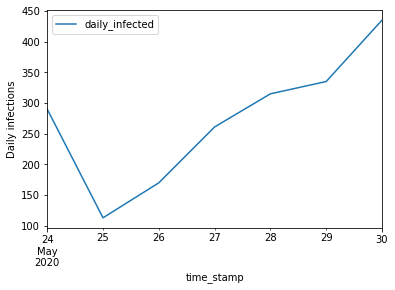

In [59]:
summary.groupby(['time_stamp']).sum().plot(y=['daily_infected'])
plt.ylabel('Daily infections')
plt.show()

### Hospital and intensive care

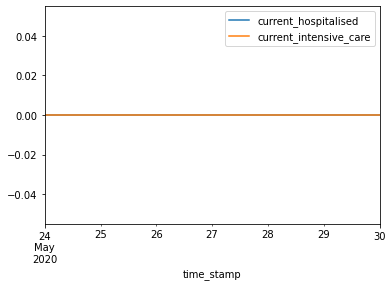

In [60]:
summary.groupby(['time_stamp']).sum().plot(y=['current_hospitalised', 'current_intensive_care'])
plt.show()

### Cumulative infections by age

In [61]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2022-09-26 09:49:20,907 - june.records.records_reader - INFO - Loading infections table
2022-09-26 09:49:20,918 - june.records.records_reader - INFO - Loading population table
2022-09-26 09:49:21,009 - june.records.records_reader - INFO - Merging infection and population tables
2022-09-26 09:49:21,018 - june.records.records_reader - INFO - Loading geography table
2022-09-26 09:49:21,045 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [62]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2022-09-26 09:49:21,060 - june.records.records_reader - INFO - Loading deaths table
2022-09-26 09:49:21,068 - june.records.records_reader - INFO - Loading population table
2022-09-26 09:49:21,127 - june.records.records_reader - INFO - Merging infection and population tables
2022-09-26 09:49:21,133 - june.records.records_reader - INFO - Loading geography table
2022-09-26 09:49:21,156 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [63]:
age_bins = (0,20,60,100)

In [64]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [65]:
people_df = read.table_to_df('population')

In [66]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

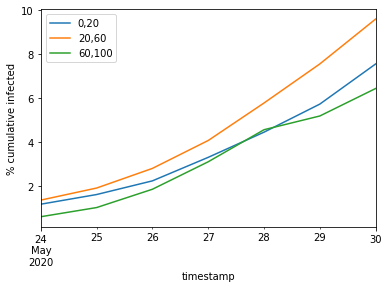

In [67]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("% cumulative infected")
plt.legend()

### Where people get infected

In [68]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

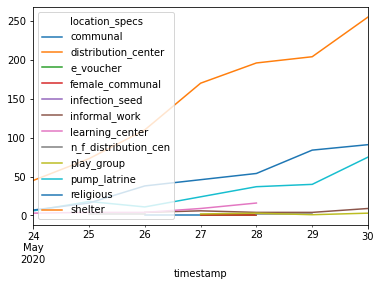

In [69]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

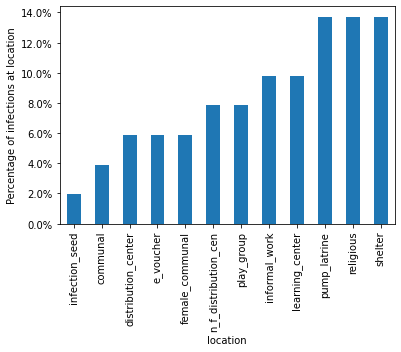

In [70]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')

# Tracker results

We can define custom binnings with bin edges as such.

In [71]:
simulator.tracker.contract_matrices("AC", np.array([0,18,60]))

1

Lastly we call the tracker to save the results to file and provide a print out of the results.

In [72]:
simulator.tracker.post_process_simulation(save=True)

Results from UNCM
  communal:
    contacts: [[3.69e+00,7.52e+00],[1.14e+00,5.81e+00]]
    contacts_err: [[8.12e-02,1.16e-01],[2.84e-02,6.42e-02]]
    proportion_physical: [[1.20e-01]]
    characteristic_time: 1.00

    Ratio of contacts and feed in values: [[7.38e-01,9.27e-01],[7.44e-01,9.68e-01]]

  distribution_center:
    contacts: [[4.14e+00,1.37e+01],[7.90e-01,1.00e+01]]
    contacts_err: [[5.67e-02,1.03e-01],[1.51e-02,5.36e-02]]
    proportion_physical: [[1.20e-01]]
    characteristic_time: 1.00

    Ratio of contacts and feed in values: [[1.04e+00,1.01e+00],[1.00e+00,1.00e+00]]

  e_voucher:
    contacts: [[3.17e-01,2.01e+00],[1.09e-01,1.37e+01]]
    contacts_err: [[2.51e-02,6.33e-02],[8.43e-03,9.47e-02]]
    proportion_physical: [[1.20e-01]]
    characteristic_time: 1.00

    Ratio of contacts and feed in values: [[0.00e+00,1.01e+00],[1.09e+00,1.02e+00]]

  female_communal:
    contacts: [[5.06e+00,8.06e+00],[1.50e+00,6.02e+00]]
    contacts_err: [[4.77e-02,6.02e-02],[2.67e-02,

1

82


65
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


{0: {'unisex': [0, 0, 0, 0, 0, 0, 0],
  'male': [0, 0, 0, 0, 0, 0, 0],
  'female': [0, 0, 0, 0, 0, 0, 0]},
 1: {'unisex': [316, 319, 308, 318, 316, 316, 319],
  'male': [158, 147, 144, 154, 151, 151, 144],
  'female': [158, 172, 164, 164, 165, 165, 175]},
 2: {'unisex': [265, 276, 262, 274, 269, 278, 266],
  'male': [109, 123, 114, 124, 116, 117, 108],
  'female': [156, 153, 148, 150, 153, 161, 158]},
 3: {'unisex': [222, 211, 209, 205, 214, 240, 242],
  'male': [100, 95, 96, 104, 98, 106, 111],
  'female': [122, 116, 113, 101, 116, 134, 131]},
 4: {'unisex': [263, 262, 267, 275, 265, 292, 284],
  'male': [111, 114, 119, 122, 111, 129, 123],
  'female': [152, 148, 148, 153, 154, 163, 161]},
 5: {'unisex': [154, 164, 156, 161, 160, 215, 224],
  'male': [63, 65, 60, 74, 65, 87, 92],
  'female': [91, 99, 96, 87, 95, 128, 132]},
 6: {'unisex': [185, 181, 197, 197, 176, 232, 232],
  'male': [82, 73, 81, 86, 76, 103, 101],
  'female': [103, 108, 116, 111, 100, 129, 131]},
 7: {'unisex': [174